# Lab 2
## Louis Gauthy (i6188059) & Louis Meeckers (i6258699)

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import ssl
from PIL import Image
from keras.preprocessing.image import array_to_img
from keras.preprocessing.image import img_to_array


from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Model

ssl._create_default_https_context = ssl._create_unverified_context

# Load the data

In [3]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalize the data
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# Concatenate
x = np.concatenate((x_train, x_test), axis=0)
y = np.concatenate((y_train, y_test), axis=0)

# 80% train, 10% validation, 10% test
x_train, x_test, _, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
x_val, x_test, _, _ = train_test_split(x_test, y_test, test_size=0.5, random_state=42)

# Print shape
print (x_train.shape) # 80% => 48 000 instances
print (x_val.shape) # 10% => 6 000 instances
print (x_test.shape) # 10% => 6 000 instances

(48000, 32, 32, 3)
(6000, 32, 32, 3)
(6000, 32, 32, 3)


In [5]:
print("max pixel values = ",np.max(x_train))
print("max pixel values = ",np.min(x_train))

1.0
0.0


# Reconstruction

## Create autoencoder

In [28]:
class Autoencoder(Model):

  def __init__(self, latent_dim = 16, input_dim = 3, output_dim = 3, strides = 1, kernel_size = 3):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim   

    self.encoder = tf.keras.Sequential([
      layers.Conv2D(8, kernel_size=kernel_size, strides=strides, padding='same', activation='relu', input_shape=(32,32,input_dim)),
      layers.AveragePooling2D(pool_size=(2, 2), padding='same'),
      layers.Conv2D(12, kernel_size=kernel_size, strides=strides, padding='same', activation='relu'),
      layers.AveragePooling2D(pool_size=(2, 2), padding='same'),
      layers.Conv2D(latent_dim, kernel_size=kernel_size, strides=strides, padding='same', activation='relu')
      # layers.Flatten(),
      # layers.Dense(latent_dim, activation='relu'),
    ])

    self.decoder = tf.keras.Sequential([
      layers.UpSampling2D(size=(2, 2)),
      layers.Conv2D(12, kernel_size=kernel_size, strides=strides, padding='same', activation='relu'),
      layers.UpSampling2D(size=(2, 2)),
      layers.Conv2D(output_dim, kernel_size=kernel_size, strides=strides, padding='same', activation='relu'),
      # layers.Reshape((32, 32, 3))
      # layers.Dense(3072, activation='sigmoid'),
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded


In [4]:
class CNNAutoencoder(Model):
    
  def __init__(self, cnn_dim = 4, latent_dim = 16, input_dim = 3, output_dim = 3, kernel_size = 3):
    super(CNNAutoencoder, self).__init__()
    self.latent_dim = latent_dim
    self.encoder_channel_sizes = np.linspace(input_dim, latent_dim, num=cnn_dim)
    self.decoder_channel_sizes = np.linspace(latent_dim, output_dim, num=cnn_dim)

    encoder_seq = []; decoder_seq = []


    for i in self.encoder_channel_sizes:
      if i == input_dim: encoder_seq.append(layers.Conv2D(i, kernel_size=kernel_size, strides=1, padding='same', activation='relu', input_shape=(32,32,input_dim)))
      elif i== latent_dim: encoder_seq.append(layers.Conv2D(i, kernel_size=kernel_size, strides=1, padding='same', activation='relu')); break
      encoder_seq.append(layers.AveragePooling2D(pool_size=(2, 2), padding='same'))

    for i in self.decoder_channel_sizes[1:]:
      decoder_seq.append(layers.UpSampling2D(size=(2, 2)))
      # decoder_seq.append(layers.AveragePooling2D(pool_size=(2, 2), padding='same'))
      decoder_seq.append(layers.Conv2DTranspose(i, kernel_size=kernel_size, strides=1, padding='same', activation='relu'))

    self.encoder = tf.keras.Sequential(encoder_seq)
    self.decoder = tf.keras.Sequential(decoder_seq)

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded


## Display structure NN

In [4]:

autoencoder = Autoencoder()
# Define optimizer and the error function
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError(), metrics = "MeanSquaredError")

In [18]:
print(autoencoder.summary())

Model: "autoencoder_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_6 (Sequential)    (None, 8, 8, 12)          1100      
_________________________________________________________________
sequential_7 (Sequential)    (None, 32, 32, 3)         3811      
Total params: 4,911
Trainable params: 4,911
Non-trainable params: 0
_________________________________________________________________
None


## Fit the data (epochs=10)

In [7]:

inital_history = autoencoder.fit(x_train, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_val, x_val))

Epoch 1/10
  18/1500 [..............................] - ETA: 2:12 - loss: 0.0701 - mean_squared_error: 0.0701

KeyboardInterrupt: 

In [4]:
def plot_training_curves(acc, val_acc, loss = None, val_loss = None, ft = False):
    
  plt.figure(figsize=(5, 5))
#   plt.subplot(2, 1, 1)
  plt.title("Train and validation MSE over the epochs")
  plt.plot(acc, label='Training MSE')
  plt.plot(val_acc, label='Validation MSE')
  plt.legend(loc='lower right')
  plt.ylabel('Error')
  plt.xlabel("epochs")
  plt.title('Training and Validation Error')

#   plt.subplot(2, 1, 2)
#   plt.plot(loss, label='Training Loss')
#   plt.plot(val_loss, label='Validation Loss')
#   plt.legend(loc='upper right')
#   plt.ylabel('Cross Entropy')
#   plt.title('Training and Validation Loss')
#   plt.xlabel('epoch')
  plt.show()

## The evolution of the Mean Squared Error with epochs

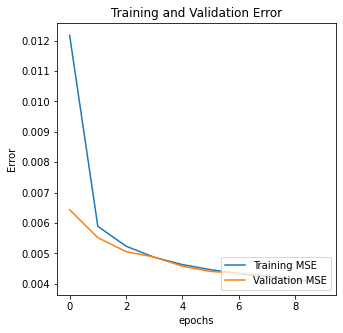

In [9]:
mse = history.history['mean_squared_error']
val_mse = history.history['val_mean_squared_error']

plot_training_curves(mse, val_mse)

It is observed here that the error is dropping in the first epochs then gradualy stabilises towards $\approx$ 0.045

## Model Evaluation

In [10]:
metrics = autoencoder.evaluate(x_test,x_test)
mae = metrics[1]
print('Test Error :', mse)

188/188 [==============================] - 2s 8ms/step - loss: 0.0040 - mean_squared_error: 0.0040
Test Error : [0.012170931324362755, 0.0058909086510539055, 0.00523773580789566, 0.004872499033808708, 0.004631478805094957, 0.004464106168597937, 0.00433002132922411, 0.0042189499363303185, 0.004124506842344999, 0.004044022876769304]


We get a similar error the last epoch's validation error

## Display some results

In [5]:
def plot_test(autoencoder,x_test,gray = False, RGB = False, x_color = None):
 encoded_imgs = autoencoder.encoder(x_test).numpy()
 decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

 if gray:
  x_test = x_test.numpy()
  if not RGB: decoded_imgs = rgb_convertion(decoded_imgs,x_test); print("RGB convertion")

 iStart = 10 # only change this value to display different value (must be >= 0)
 n = 10
 plt.figure(figsize=(20, 4))
 for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  if gray: plt.imshow((x_test[iStart + i].T[0][:][:]).T)
  else: plt.imshow(x_test[iStart + i])

  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[iStart + i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
 
 if gray:
  plt.figure(figsize=(20,10))
 for i in range(0,10):
  ax = plt.subplot(2, 10,i+1)
  plt.imshow(x_color[iStart + i])
  plt.title("colored")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
 plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


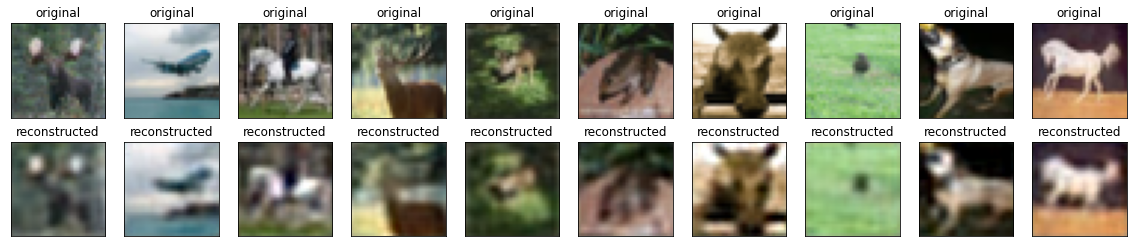

In [238]:
plot_test(autoencoder,x_test)

# Latent space

In [13]:
s = 1 #strides
c = 16 #channels
w = 32*3 #input volume
k = 3 #kernel size
p = (k-1)/2 #padding (forumla is for padding = same!)

def lspace_size(c,k,s,w,p = (k-1)/2):
   return c*np.power(1+ w-k+2*p/s,2)

print("latent space size = ",lspace_size(c,k,s,w))

latent space size =  147456.0


# Hyper parameter tuning
> e.g. fewer intermediate layers, different number of channels, filter sizes or stride and
padding configurations) 
-> What is the impact of those in the reconstruction error after training? Is there an obvious correlation between the size of the latent space representation and the error?

In [149]:
def build_ae(latent_dim = 16, verbose = 0):
    autoencoder = Autoencoder(latent_dim)
   # Define optimizer and the error function
    autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError(), metrics = "MeanSquaredError")
    history = autoencoder.fit(x_train, x_train,
                epochs=10,
                shuffle=True,
                verbose=verbose,
                validation_data=(x_val, x_val))
    return history.history['val_mean_squared_error']

error = build_ae(latent_dim = 32)
print(error)



[0.056905053555965424, 0.05250124633312225, 0.049826331436634064, 0.04696568846702576, 0.045732565224170685, 0.046203386038541794, 0.044304873794317245, 0.043693382292985916, 0.044312283396720886, 0.042922258377075195]


In [161]:
# Is there an obvious correlation between the size of the latent space representation and the error?
dims = np.power(2,np.arange(1,12,1))

errors = []
for dim in dims:
    error = build_ae(latent_dim = 32)
    errors.append(error[len(error)]

  

[    2     4     8    16    32    64   128   256   512  1024  2048  4096
  8192 16384]


# Colorization

## RGB convertion to YCbCr

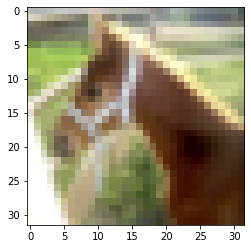

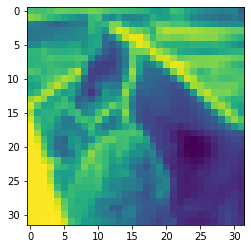

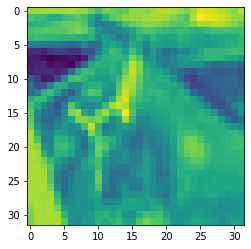

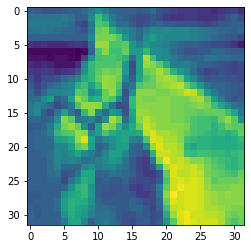

In [200]:
im_arr = x_test[1]
image = array_to_img(im_arr)
plt.imshow(image)
ycbcr = image.convert('YCbCr')
y, cb, cr = ycbcr.split()


y_arr = np.array(y)
cb_arr = np.array(cb)
cr_arr = np.array(cr)
c_arr = np.dstack((cb_arr,cr_arr))
plt.figure()
plt.imshow(y)
plt.figure()
plt.imshow(cb)
plt.figure()
plt.imshow(cr)


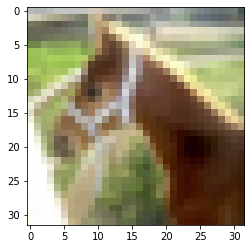

In [217]:
y_re = Image.fromarray(y_arr, mode ="L")
cb_arr= (c_arr.T[0][:][:]).T
cr_arr= (c_arr.T[1][:][:]).T
cb_re = Image.fromarray(cb_arr, mode ="L")
cr_re = Image.fromarray(cr_arr, mode ="L")

x= Image.merge('YCbCr', (y_re, cb_re, cr_re)).convert('RGB')

plt.imshow(x)

In [157]:
x_train.dtype

dtype('float32')

In [6]:
def lum_chrom_convertion(data):
 chromas = []
 luminas = []
 for im_arr in data:
  ycbcr = array_to_img(im_arr).convert('YCbCr')
  y, cb, cr = ycbcr.split()
  luminas.append(np.array(y))
  chromas.append(np.dstack((np.array(cb),np.array(cr))))
 return [np.array(chromas).astype("float32")/255,np.array(luminas).astype("float32")/255]

def rgb_convertion(chrom,lum):
 chrom = (chrom*255).astype("uint8")
 lum = (lum*255).astype("uint8")         
 rgbs = []
 for i in range(len(lum)):
  y_re = Image.fromarray((lum[i].T[0][:][:]).T, mode ="L")
  c_arr = chrom[i]
  cb_re = Image.fromarray((c_arr.T[0][:][:]).T, mode ="L")
  cr_re = Image.fromarray((c_arr.T[1][:][:]).T, mode ="L")
  x= Image.merge('YCbCr', (y_re, cb_re, cr_re)).convert("RGB")
  rgbs.append(np.array(x))
 return rgbs

def gray_convertion(data):
    grays=[]
    for im_arr in data:
       gray = array_to_img(im_arr).convert('L')
       gray_arr = np.array(gray)
       grays.append((gray_arr))
    grays = np.array(grays).astype("float32")/255
    return tf.expand_dims(grays, axis=-1)


In [7]:
[chrom_test,lum_test] = lum_chrom_convertion(x_test)
[chrom_train,lum_train] = lum_chrom_convertion(x_train)
[chrom_val,lum_val] = lum_chrom_convertion(x_val)

gray_test = gray_convertion(x_test)
gray_train = gray_convertion(x_train)
gray_val = gray_convertion(x_val)

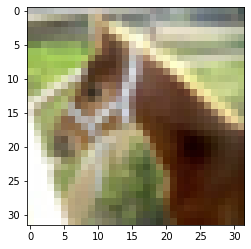

In [163]:
test_re = rgb_convertion(chrom_test,gray_test.numpy())
plt.imshow(test_re[1])

## Training

## A first Autoencoder, predicting RGB

Epoch 1/10
1500/1500 [==============================] - 69s 45ms/step - loss: 0.0179 - mean_squared_error: 0.0179 - val_loss: 0.0130 - val_mean_squared_error: 0.0130
Epoch 2/10
1500/1500 [==============================] - 63s 42ms/step - loss: 0.0127 - mean_squared_error: 0.0127 - val_loss: 0.0123 - val_mean_squared_error: 0.0123
Epoch 3/10
1500/1500 [==============================] - 82s 55ms/step - loss: 0.0120 - mean_squared_error: 0.0120 - val_loss: 0.0116 - val_mean_squared_error: 0.0116
Epoch 4/10
1500/1500 [==============================] - 70s 47ms/step - loss: 0.0116 - mean_squared_error: 0.0116 - val_loss: 0.0111 - val_mean_squared_error: 0.0111
Epoch 5/10
1500/1500 [==============================] - 64s 43ms/step - loss: 0.0113 - mean_squared_error: 0.0113 - val_loss: 0.0109 - val_mean_squared_error: 0.0109
Epoch 6/10
1500/1500 [==============================] - 64s 43ms/step - loss: 0.0111 - mean_squared_error: 0.0111 - val_loss: 0.0107 - val_mean_squared_error: 0.0107
Epoc

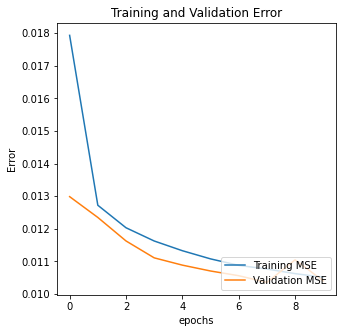

In [11]:
gray_ae = Autoencoder(latent_dim=64,input_dim=1,output_dim=3)
# Define optimizer and the error function
gray_ae.compile(optimizer='adam', loss=losses.MeanSquaredError(), metrics = "MeanSquaredError")
gray_history = gray_ae.fit(gray_train, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(gray_val, x_val))
mse = gray_history.history['mean_squared_error']
val_mse = gray_history.history['val_mean_squared_error']

plot_training_curves(mse, val_mse)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


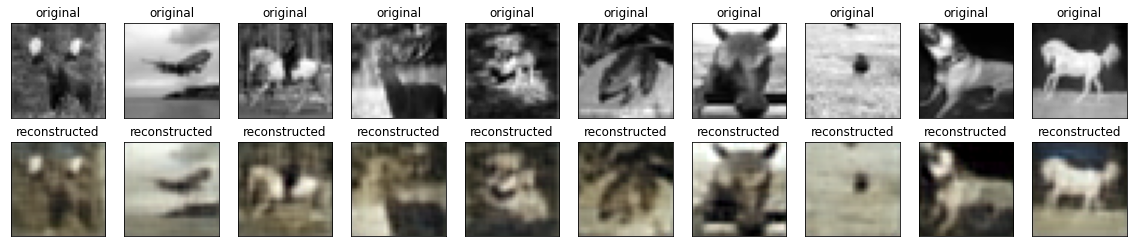

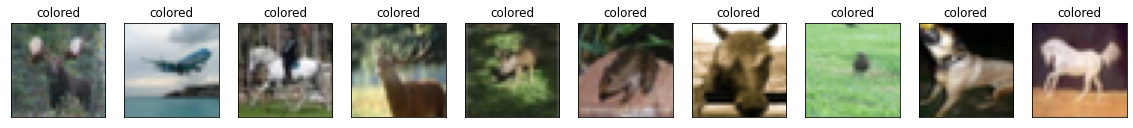

In [12]:
plot_test(gray_ae,gray_test,gray = True,RGB = True,x_color = x_test)

## An autoencoder, predicting the chrominance

Epoch 1/10
1500/1500 [==============================] - 63s 42ms/step - loss: 0.0070 - mean_squared_error: 0.0070 - val_loss: 0.0042 - val_mean_squared_error: 0.0042
Epoch 2/10
1500/1500 [==============================] - 65s 44ms/step - loss: 0.0041 - mean_squared_error: 0.0041 - val_loss: 0.0041 - val_mean_squared_error: 0.0041
Epoch 3/10
1500/1500 [==============================] - 67s 45ms/step - loss: 0.0039 - mean_squared_error: 0.0039 - val_loss: 0.0038 - val_mean_squared_error: 0.0038
Epoch 4/10
1500/1500 [==============================] - 64s 42ms/step - loss: 0.0038 - mean_squared_error: 0.0038 - val_loss: 0.0036 - val_mean_squared_error: 0.0036
Epoch 5/10
1500/1500 [==============================] - 62s 41ms/step - loss: 0.0038 - mean_squared_error: 0.0038 - val_loss: 0.0037 - val_mean_squared_error: 0.0037
Epoch 6/10
1500/1500 [==============================] - 63s 42ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - val_loss: 0.0036 - val_mean_squared_error: 0.0036
Epoc

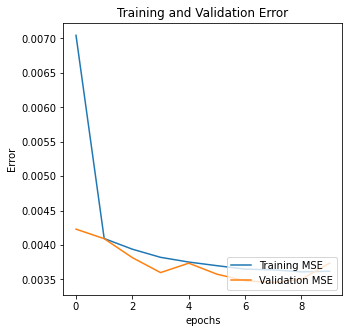

In [13]:
gray_ae = Autoencoder(latent_dim=64,input_dim=1,output_dim=2)
# Define optimizer and the error function
gray_ae.compile(optimizer='adam', loss=losses.MeanSquaredError(), metrics = "MeanSquaredError")
gray_history = gray_ae.fit(gray_train, chrom_train,
                epochs=10,
                shuffle=True,
                validation_data=(gray_val, chrom_val))

mse = gray_history.history['mean_squared_error']
val_mse = gray_history.history['val_mean_squared_error']

plot_training_curves(mse, val_mse)

188/188 [==============================] - 2s 9ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Test Error : [0.007045206148177385, 0.0040941801853477955, 0.0039391834288835526, 0.0038211578503251076, 0.0037525820080190897, 0.0036998384166508913, 0.0036495106760412455, 0.003638981143012643, 0.0036100740544497967, 0.003619079478085041]
RGB convertion


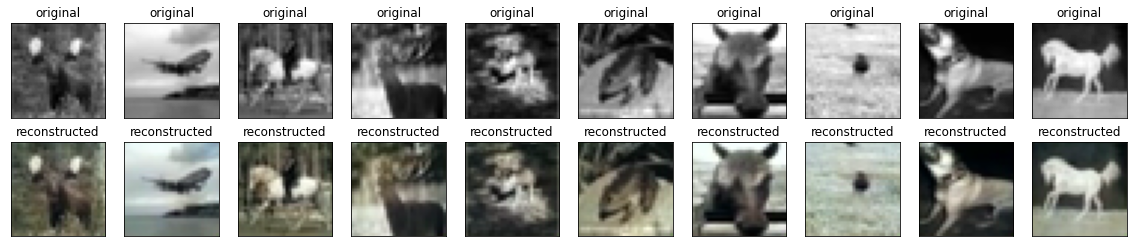

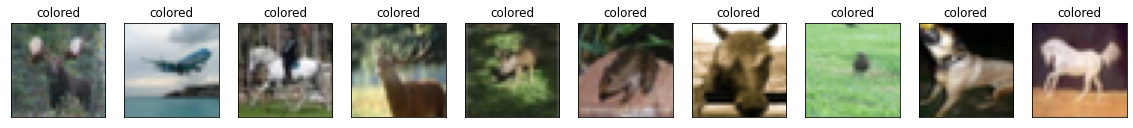

In [14]:
metrics = gray_ae.evaluate(gray_test,chrom_test)
mae = metrics[1]
print('Test Error :', mse)

plot_test(gray_ae,gray_test,gray = True,x_color = x_test)

## Larger strides

In [117]:
class Autoencoder(Model):
    
  def __init__(self, latent_dim = 16, input_dim = 3, output_dim = 3, strides = 1, kernel_size = 3):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim   

    self.encoder = tf.keras.Sequential([
      layers.Conv2D(8, kernel_size=kernel_size, strides=1, padding='same', activation='relu', input_shape=(32,32,input_dim)),
    #   layers.AveragePooling2D(pool_size=(2, 2), padding='same'),
      layers.Conv2D(12, kernel_size=kernel_size, strides=strides, padding='same', activation='relu'),
    #   layers.AveragePooling2D(pool_size=(2, 2), padding='same'),
      layers.Conv2D(latent_dim, kernel_size=kernel_size, strides=strides, padding='same', activation='relu')
      # layers.Flatten(),
      # layers.Dense(latent_dim, activation='relu'),
    ])

    self.decoder = tf.keras.Sequential([
      layers.UpSampling2D(size=(strides-1,strides-1)),
      layers.Conv2D(12, kernel_size=kernel_size, strides=1, padding='same', activation='relu'),
      layers.UpSampling2D(size=(strides+1, strides+1)),
      layers.Conv2D(output_dim, kernel_size=kernel_size, strides=1, padding='same', activation='relu'),
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded


Epoch 1/10
1500/1500 [==============================] - 42s 28ms/step - loss: 0.0071 - mean_squared_error: 0.0071 - val_loss: 0.0042 - val_mean_squared_error: 0.0042
Epoch 2/10
1500/1500 [==============================] - 41s 27ms/step - loss: 0.0042 - mean_squared_error: 0.0042 - val_loss: 0.0043 - val_mean_squared_error: 0.0043
Epoch 3/10
1500/1500 [==============================] - 41s 27ms/step - loss: 0.0041 - mean_squared_error: 0.0041 - val_loss: 0.0038 - val_mean_squared_error: 0.0038
Epoch 4/10
1500/1500 [==============================] - 40s 27ms/step - loss: 0.0039 - mean_squared_error: 0.0039 - val_loss: 0.0038 - val_mean_squared_error: 0.0038
Epoch 5/10
1500/1500 [==============================] - 41s 27ms/step - loss: 0.0038 - mean_squared_error: 0.0038 - val_loss: 0.0038 - val_mean_squared_error: 0.0038
Epoch 6/10
1500/1500 [==============================] - 42s 28ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - val_loss: 0.0037 - val_mean_squared_error: 0.0037
Epoc

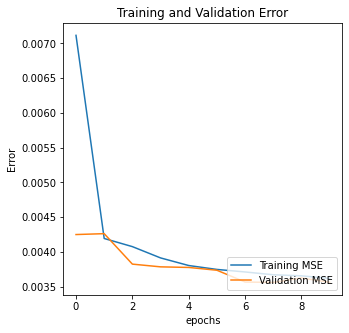

In [118]:
gray_ae = Autoencoder(latent_dim=64,input_dim=1,output_dim=2, strides = 3)
# Define optimizer and the error function
gray_ae.compile(optimizer='adam', loss=losses.MeanSquaredError(), metrics = "MeanSquaredError")
gray_history = gray_ae.fit(gray_train, chrom_train,
                epochs=10,
                shuffle=True,
                validation_data=(gray_val, chrom_val))

mse = gray_history.history['mean_squared_error']
val_mse = gray_history.history['val_mean_squared_error']

plot_training_curves(mse, val_mse)

188/188 [==============================] - 1s 7ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Test Error : [0.0071157715283334255, 0.004192621447145939, 0.004075559787452221, 0.003913127351552248, 0.003803529078140855, 0.003747316775843501, 0.0037109702825546265, 0.003670720849186182, 0.0036552315577864647, 0.0036176990251988173]
RGB convertion


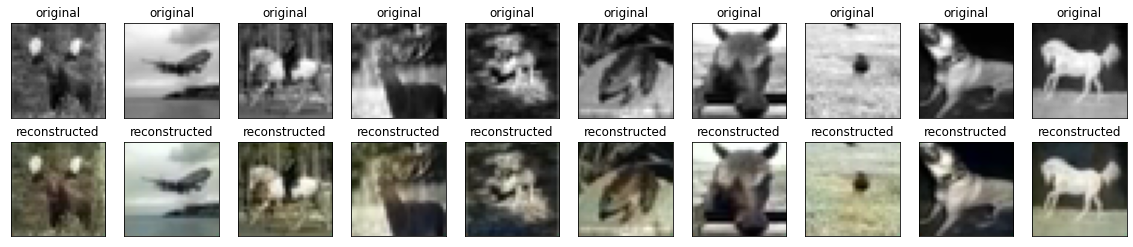

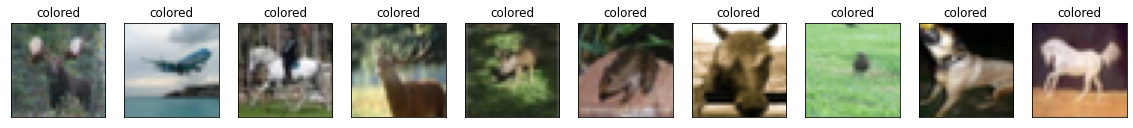

In [119]:
metrics = gray_ae.evaluate(gray_test,chrom_test)
mae = metrics[1]
print('Test Error :', mse)
plot_test(gray_ae,gray_test,gray = True,x_color = x_test)

## Larger strides with dense sigmoid last layer

In [114]:
class Autoencoder(Model):
    
  def __init__(self, latent_dim = 16, input_dim = 3, output_dim = 3, strides = 1, kernel_size = 3):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim   

    self.encoder = tf.keras.Sequential([
      layers.Conv2D(8, kernel_size=kernel_size, strides=1, padding='same', activation='relu', input_shape=(32,32,input_dim)),
    #   layers.AveragePooling2D(pool_size=(2, 2), padding='same'),
      layers.Conv2D(12, kernel_size=kernel_size, strides=strides, padding='same', activation='relu'),
    #   layers.AveragePooling2D(pool_size=(2, 2), padding='same'),
      layers.Conv2D(latent_dim, kernel_size=kernel_size, strides=strides, padding='same', activation='relu')
      # layers.Flatten(),
      # layers.Dense(latent_dim, activation='relu'),
    ])

    self.decoder = tf.keras.Sequential([
      layers.UpSampling2D(size=(strides-1,strides-1)),
      layers.Conv2D(12, kernel_size=kernel_size, strides=1, padding='same', activation='relu'),
      layers.UpSampling2D(size=(strides+1, strides+1)),
      layers.Conv2D(8, kernel_size=kernel_size, strides=1, padding='same', activation='relu'),
      layers.Dense(output_dim, activation='sigmoid')
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded


Epoch 1/10
1500/1500 [==============================] - 64s 43ms/step - loss: 0.0039 - mean_squared_error: 0.0039 - val_loss: 0.0037 - val_mean_squared_error: 0.0037
Epoch 2/10
1500/1500 [==============================] - 64s 42ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - val_loss: 0.0036 - val_mean_squared_error: 0.0036
Epoch 3/10
1500/1500 [==============================] - 64s 43ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - val_loss: 0.0036 - val_mean_squared_error: 0.0036
Epoch 4/10
1500/1500 [==============================] - 63s 42ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - val_loss: 0.0035 - val_mean_squared_error: 0.0035
Epoch 5/10
1500/1500 [==============================] - 63s 42ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - val_loss: 0.0035 - val_mean_squared_error: 0.0035
Epoch 6/10
1500/1500 [==============================] - 65s 43ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - val_loss: 0.0035 - val_mean_squared_error: 0.0035
Epoc

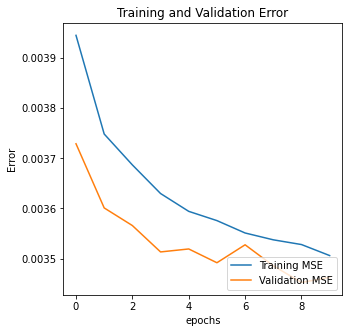

In [105]:
gray_ae = Autoencoder(latent_dim=64,input_dim=1,output_dim=2, strides = 3)
# Define optimizer and the error function
gray_ae.compile(optimizer='adam', loss=losses.MeanSquaredError(), metrics = "MeanSquaredError")
gray_history = gray_ae.fit(gray_train, chrom_train,
                epochs=10,
                shuffle=True,
                validation_data=(gray_val, chrom_val))

mse = gray_history.history['mean_squared_error']
val_mse = gray_history.history['val_mean_squared_error']

plot_training_curves(mse, val_mse)

188/188 [==============================] - 2s 10ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Test Error : [0.003945089876651764, 0.0037484322674572468, 0.003686854150146246, 0.0036298225168138742, 0.0035942678805440664, 0.0035758463200181723, 0.0035511506721377373, 0.0035375459119677544, 0.003528114641085267, 0.0035061617381870747]
RGB convertion


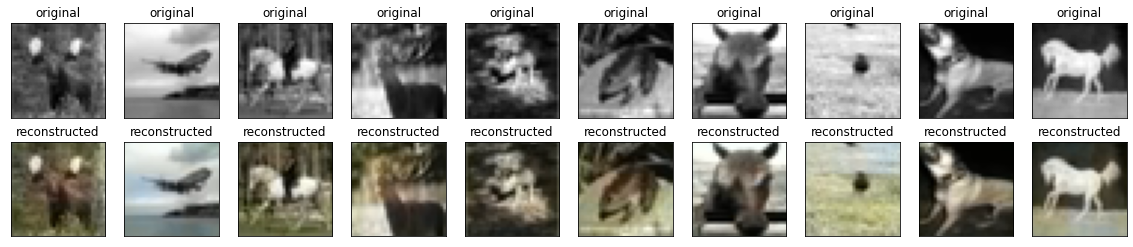

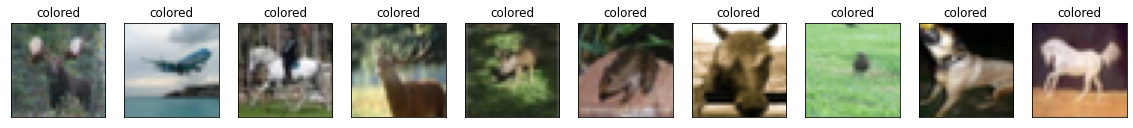

In [106]:
metrics = gray_ae.evaluate(gray_test,chrom_test)
mae = metrics[1]
print('Test Error :', mse)
plot_test(gray_ae,gray_test,gray = True,x_color = x_test)

## Larger strides with dense relu last layer

In [ ]:
class Autoencoder(Model):
    
  def __init__(self, latent_dim = 16, input_dim = 3, output_dim = 3, strides = 1, kernel_size = 3):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim   

    self.encoder = tf.keras.Sequential([
      layers.Conv2D(8, kernel_size=kernel_size, strides=1, padding='same', activation='relu', input_shape=(32,32,input_dim)),
    #   layers.AveragePooling2D(pool_size=(2, 2), padding='same'),
      layers.Conv2D(12, kernel_size=kernel_size, strides=strides, padding='same', activation='relu'),
    #   layers.AveragePooling2D(pool_size=(2, 2), padding='same'),
      layers.Conv2D(latent_dim, kernel_size=kernel_size, strides=strides, padding='same', activation='relu')
      # layers.Flatten(),
      # layers.Dense(latent_dim, activation='relu'),
    ])

    self.decoder = tf.keras.Sequential([
      layers.UpSampling2D(size=(strides-1,strides-1)),
      layers.Conv2D(12, kernel_size=kernel_size, strides=1, padding='same', activation='relu'),
      layers.UpSampling2D(size=(strides+1, strides+1)),
      layers.Conv2D(8, kernel_size=kernel_size, strides=1, padding='same', activation='relu'),
      layers.Dense(output_dim, activation='relu')
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded


Epoch 1/10
1500/1500 [==============================] - 64s 41ms/step - loss: 0.0056 - mean_squared_error: 0.0056 - val_loss: 0.0041 - val_mean_squared_error: 0.0041
Epoch 2/10
1500/1500 [==============================] - 64s 42ms/step - loss: 0.0041 - mean_squared_error: 0.0041 - val_loss: 0.0040 - val_mean_squared_error: 0.0040
Epoch 3/10
1500/1500 [==============================] - 60s 40ms/step - loss: 0.0040 - mean_squared_error: 0.0040 - val_loss: 0.0040 - val_mean_squared_error: 0.0040
Epoch 4/10
1500/1500 [==============================] - 46s 31ms/step - loss: 0.0039 - mean_squared_error: 0.0039 - val_loss: 0.0040 - val_mean_squared_error: 0.0040
Epoch 5/10
1500/1500 [==============================] - 46s 31ms/step - loss: 0.0038 - mean_squared_error: 0.0038 - val_loss: 0.0036 - val_mean_squared_error: 0.0036
Epoch 6/10
1500/1500 [==============================] - 58s 39ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - val_loss: 0.0035 - val_mean_squared_error: 0.0035
Epoc

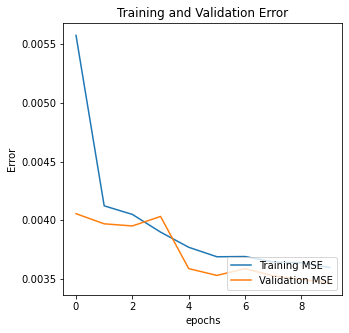

In [115]:
gray_ae = Autoencoder(latent_dim=64,input_dim=1,output_dim=2, strides = 3)
# Define optimizer and the error function
gray_ae.compile(optimizer='adam', loss=losses.MeanSquaredError(), metrics = "MeanSquaredError")
gray_history = gray_ae.fit(gray_train, chrom_train,
                epochs=10,
                shuffle=True,
                validation_data=(gray_val, chrom_val))

mse = gray_history.history['mean_squared_error']
val_mse = gray_history.history['val_mean_squared_error']

plot_training_curves(mse, val_mse)

188/188 [==============================] - 1s 7ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Test Error : [0.005574693903326988, 0.004122835583984852, 0.004049739334732294, 0.0038990878965705633, 0.00376988691277802, 0.0036891591735184193, 0.0036911398638039827, 0.0036446438170969486, 0.0036383834667503834, 0.0035979582462459803]
RGB convertion


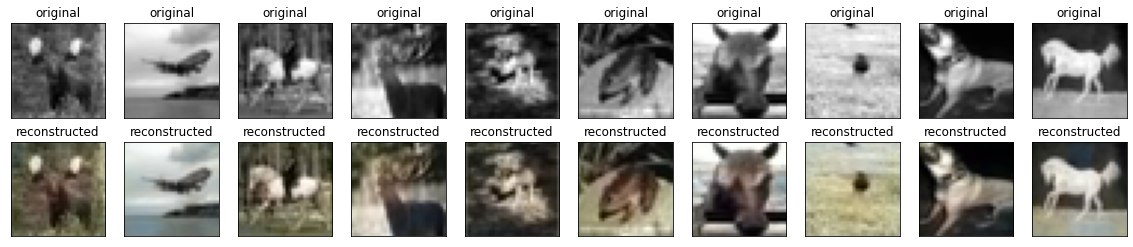

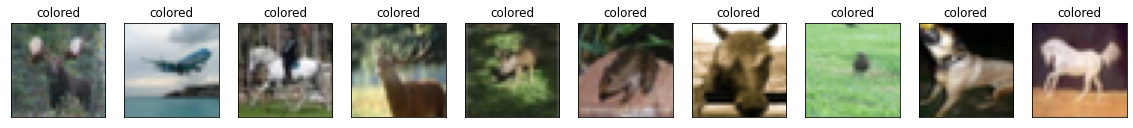

In [116]:
metrics = gray_ae.evaluate(gray_test,chrom_test)
mae = metrics[1]
print('Test Error :', mse)
plot_test(gray_ae,gray_test,gray = True,x_color = x_test)

## Larger kernel

Epoch 1/10
1500/1500 [==============================] - 182s 121ms/step - loss: 0.0056 - mean_squared_error: 0.0056 - val_loss: 0.0039 - val_mean_squared_error: 0.0039
Epoch 2/10
1500/1500 [==============================] - 181s 121ms/step - loss: 0.0040 - mean_squared_error: 0.0040 - val_loss: 0.0037 - val_mean_squared_error: 0.0037
Epoch 3/10
1500/1500 [==============================] - 186s 124ms/step - loss: 0.0039 - mean_squared_error: 0.0039 - val_loss: 0.0037 - val_mean_squared_error: 0.0037
Epoch 4/10
1500/1500 [==============================] - 187s 125ms/step - loss: 0.0038 - mean_squared_error: 0.0038 - val_loss: 0.0038 - val_mean_squared_error: 0.0038
Epoch 5/10
1500/1500 [==============================] - 186s 124ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - val_loss: 0.0035 - val_mean_squared_error: 0.0035
Epoch 6/10
1500/1500 [==============================] - 186s 124ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - val_loss: 0.0035 - val_mean_squared_error:

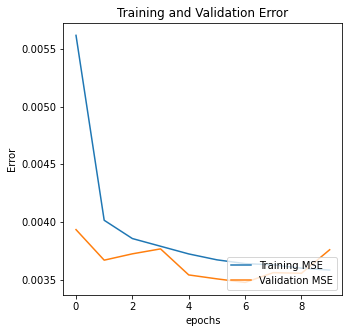

In [223]:
gray_ae = Autoencoder(latent_dim=64,input_dim=1,output_dim=2, kernel_size = 5)
# Define optimizer and the error function
gray_ae.compile(optimizer='adam', loss=losses.MeanSquaredError(), metrics = "MeanSquaredError")
gray_history = gray_ae.fit(gray_train, chrom_train,
                epochs=10,
                shuffle=True,
                validation_data=(gray_val, chrom_val))

mse = gray_history.history['mean_squared_error']
val_mse = gray_history.history['val_mean_squared_error']

plot_training_curves(mse, val_mse)

188/188 [==============================] - 3s 18ms/step - loss: 0.0039 - mean_squared_error: 0.0039
Test Error : [0.005618707742542028, 0.004014070611447096, 0.003855489194393158, 0.0037887876387685537, 0.003722053486853838, 0.003670909209176898, 0.0036378148943185806, 0.0036276481114327908, 0.0035982176195830107, 0.0035819807089865208]
RGB convertion


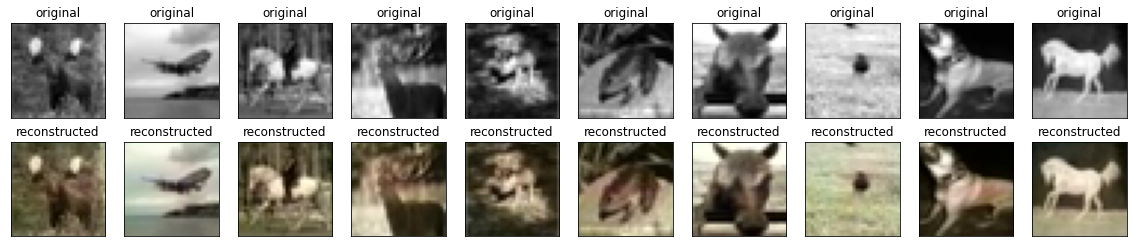

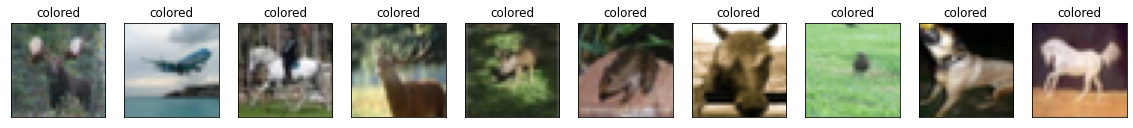

In [227]:
metrics = gray_ae.evaluate(gray_test,chrom_test)
mae = metrics[1]
print('Test Error :', mse)

plot_test(gray_ae,gray_test,gray = True,x_color = x_test)

## Even larger kernel

Epoch 1/10
1500/1500 [==============================] - 276s 183ms/step - loss: 0.0057 - mean_squared_error: 0.0057 - val_loss: 0.0041 - val_mean_squared_error: 0.0041
Epoch 2/10
1500/1500 [==============================] - 244s 163ms/step - loss: 0.0040 - mean_squared_error: 0.0040 - val_loss: 0.0042 - val_mean_squared_error: 0.0042
Epoch 3/10
1500/1500 [==============================] - 251s 167ms/step - loss: 0.0039 - mean_squared_error: 0.0039 - val_loss: 0.0036 - val_mean_squared_error: 0.0036
Epoch 4/10
1500/1500 [==============================] - 257s 171ms/step - loss: 0.0038 - mean_squared_error: 0.0038 - val_loss: 0.0042 - val_mean_squared_error: 0.0042
Epoch 5/10
1500/1500 [==============================] - 254s 169ms/step - loss: 0.0038 - mean_squared_error: 0.0038 - val_loss: 0.0036 - val_mean_squared_error: 0.0036
Epoch 6/10
1500/1500 [==============================] - 255s 170ms/step - loss: 0.0038 - mean_squared_error: 0.0038 - val_loss: 0.0036 - val_mean_squared_error:

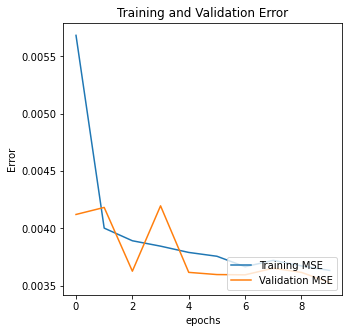

In [228]:
gray_ae = Autoencoder(latent_dim=64,input_dim=1,output_dim=2, kernel_size = 7)
# Define optimizer and the error function
gray_ae.compile(optimizer='adam', loss=losses.MeanSquaredError(), metrics = "MeanSquaredError")
gray_history = gray_ae.fit(gray_train, chrom_train,
                epochs=10,
                shuffle=True,
                validation_data=(gray_val, chrom_val))

mse = gray_history.history['mean_squared_error']
val_mse = gray_history.history['val_mean_squared_error']

plot_training_curves(mse, val_mse)

In [229]:
metrics = gray_ae.evaluate(gray_test,chrom_test)
mae = metrics[1]
print('Test Error :', mse)

plot_test(gray_ae,gray_test,gray = True,x_color = x_test)

188/188 [==============================] - 4s 24ms/step - loss: 0.0036 - mean_squared_error: 0.0036
Test Error : [0.005684325005859137, 0.004002278205007315, 0.003891903907060623, 0.0038448511622846127, 0.003790042130276561, 0.003756695194169879, 0.003665317315608263, 0.003721063956618309, 0.0036725972313433886, 0.0036328118294477463]


## Smaller Kernel

Epoch 1/10
1500/1500 [==============================] - 39s 26ms/step - loss: 0.0076 - mean_squared_error: 0.0076 - val_loss: 0.0041 - val_mean_squared_error: 0.0041
Epoch 2/10
1500/1500 [==============================] - 40s 27ms/step - loss: 0.0042 - mean_squared_error: 0.0042 - val_loss: 0.0040 - val_mean_squared_error: 0.0040
Epoch 3/10
1500/1500 [==============================] - 42s 28ms/step - loss: 0.0042 - mean_squared_error: 0.0042 - val_loss: 0.0040 - val_mean_squared_error: 0.0040
Epoch 4/10
1500/1500 [==============================] - 41s 27ms/step - loss: 0.0041 - mean_squared_error: 0.0041 - val_loss: 0.0042 - val_mean_squared_error: 0.0042
Epoch 5/10
1500/1500 [==============================] - 41s 27ms/step - loss: 0.0041 - mean_squared_error: 0.0041 - val_loss: 0.0039 - val_mean_squared_error: 0.0039
Epoch 6/10
1500/1500 [==============================] - 40s 27ms/step - loss: 0.0040 - mean_squared_error: 0.0040 - val_loss: 0.0039 - val_mean_squared_error: 0.0039
Epoc

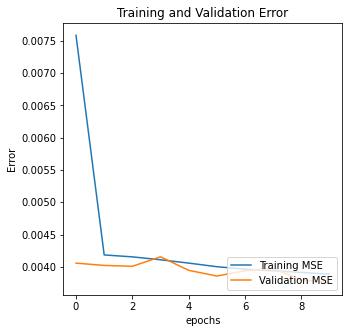

In [15]:
gray_ae = Autoencoder(latent_dim=64,input_dim=1,output_dim=2, kernel_size = 2)
# Define optimizer and the error function
gray_ae.compile(optimizer='adam', loss=losses.MeanSquaredError(), metrics = "MeanSquaredError")
gray_history = gray_ae.fit(gray_train, chrom_train,
                epochs=10,
                shuffle=True,
                validation_data=(gray_val, chrom_val))

mse = gray_history.history['mean_squared_error']
val_mse = gray_history.history['val_mean_squared_error']

plot_training_curves(mse, val_mse)

188/188 [==============================] - 1s 7ms/step - loss: 0.0038 - mean_squared_error: 0.0038
Test Error : [0.007583258207887411, 0.004185278434306383, 0.004155210684984922, 0.004110286012291908, 0.0040588704869151115, 0.004002876579761505, 0.003964828327298164, 0.0039397310465574265, 0.003914194647222757, 0.0038874077145010233]
RGB convertion


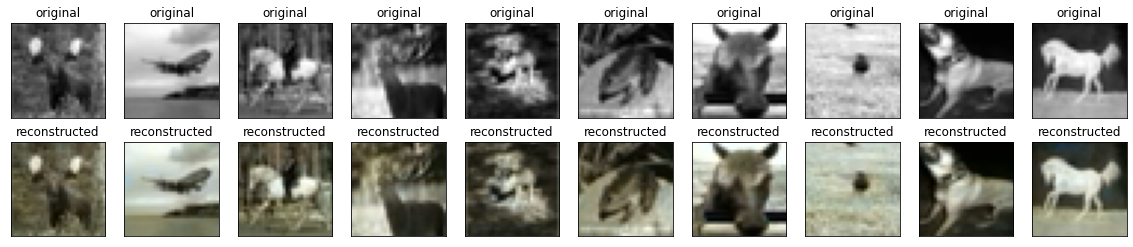

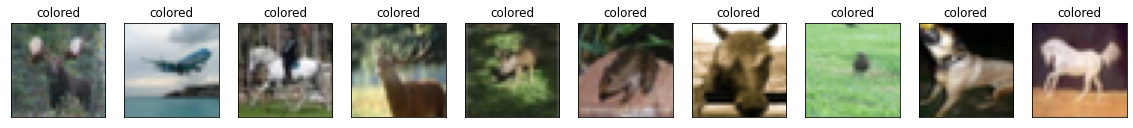

In [16]:
metrics = gray_ae.evaluate(gray_test,chrom_test)
mae = metrics[1]
print('Test Error :', mse)

plot_test(gray_ae,gray_test,gray = True,x_color = x_test)

## sigmoid with larger kernel

In [120]:
class Autoencoder(Model):
    
  def __init__(self, latent_dim = 16, input_dim = 3, output_dim = 3, strides = 1, kernel_size = 3):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim   

    self.encoder = tf.keras.Sequential([
      layers.Conv2D(8, kernel_size=kernel_size, strides=1, padding='same', activation='relu', input_shape=(32,32,input_dim)),
    #   layers.AveragePooling2D(pool_size=(2, 2), padding='same'),
      layers.Conv2D(12, kernel_size=kernel_size, strides=strides, padding='same', activation='relu'),
    #   layers.AveragePooling2D(pool_size=(2, 2), padding='same'),
      layers.Conv2D(latent_dim, kernel_size=kernel_size, strides=strides, padding='same', activation='relu')
      # layers.Flatten(),
      # layers.Dense(latent_dim, activation='relu'),
    ])

    self.decoder = tf.keras.Sequential([
      layers.UpSampling2D(size=(strides-1,strides-1)),
      layers.Conv2D(12, kernel_size=kernel_size, strides=1, padding='same', activation='relu'),
      layers.UpSampling2D(size=(strides+1, strides+1)),
      layers.Conv2D(8, kernel_size=kernel_size, strides=1, padding='same', activation='relu'),
      layers.Dense(output_dim, activation='sigmoid')
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded


Epoch 1/10
1500/1500 [==============================] - 121s 80ms/step - loss: 0.0039 - mean_squared_error: 0.0039 - val_loss: 0.0038 - val_mean_squared_error: 0.0038
Epoch 2/10
1500/1500 [==============================] - 122s 81ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - val_loss: 0.0036 - val_mean_squared_error: 0.0036
Epoch 3/10
1500/1500 [==============================] - 120s 80ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - val_loss: 0.0035 - val_mean_squared_error: 0.0035
Epoch 4/10
1500/1500 [==============================] - 120s 80ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - val_loss: 0.0035 - val_mean_squared_error: 0.0035
Epoch 5/10
1500/1500 [==============================] - 124s 83ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - val_loss: 0.0035 - val_mean_squared_error: 0.0035
Epoch 6/10
1500/1500 [==============================] - 122s 81ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - val_loss: 0.0035 - val_mean_squared_error: 0.003

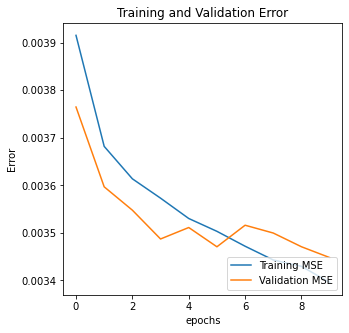

In [121]:
gray_ae = Autoencoder(latent_dim=64,input_dim=1,output_dim=2, strides=3, kernel_size = 5)
# Define optimizer and the error function
gray_ae.compile(optimizer='adam', loss=losses.MeanSquaredError(), metrics = "MeanSquaredError")
gray_history = gray_ae.fit(gray_train, chrom_train,
                epochs=10,
                shuffle=True,
                validation_data=(gray_val, chrom_val))

mse = gray_history.history['mean_squared_error']
val_mse = gray_history.history['val_mean_squared_error']

plot_training_curves(mse, val_mse)

188/188 [==============================] - 3s 15ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Test Error : [0.003915311302989721, 0.003681872971355915, 0.0036136747803539038, 0.003572972258552909, 0.0035302310716360807, 0.0035032485611736774, 0.003471923526376486, 0.003443018300458789, 0.003429632168263197, 0.0033957581035792828]
RGB convertion


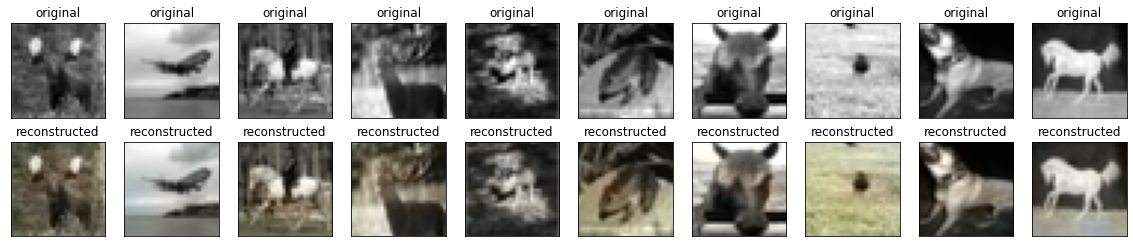

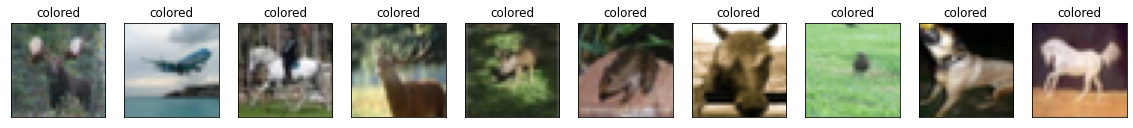

In [122]:
metrics = gray_ae.evaluate(gray_test,chrom_test)
mae = metrics[1]
print('Test Error :', mse)

plot_test(gray_ae,gray_test,gray = True,x_color = x_test)

## One extra dense layer

In [129]:
class Autoencoder(Model):
    
  def __init__(self, latent_dim = 16, input_dim = 3, output_dim = 3, strides = 1, kernel_size = 3):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim   

    self.encoder = tf.keras.Sequential([
      layers.Conv2D(8, kernel_size=kernel_size, strides=1, padding='same', activation='relu', input_shape=(32,32,input_dim)),
    #   layers.AveragePooling2D(pool_size=(2, 2), padding='same'),
      layers.Conv2D(12, kernel_size=kernel_size, strides=strides, padding='same', activation='relu'),
    #   layers.AveragePooling2D(pool_size=(2, 2), padding='same'),
      layers.Conv2D(latent_dim, kernel_size=kernel_size, strides=strides, padding='same', activation='relu')
      # layers.Flatten(),
      # layers.Dense(latent_dim, activation='relu'),
    ])

    self.decoder = tf.keras.Sequential([
      layers.UpSampling2D(size=(strides-1,strides-1)),
      layers.Conv2D(12, kernel_size=kernel_size, strides=1, padding='same', activation='relu'),
      layers.UpSampling2D(size=(strides+1, strides+1)),
      layers.Conv2D(8, kernel_size=kernel_size, strides=1, padding='same', activation='relu'),
      layers.Dense(output_dim, activation='relu'),
      layers.Dense(output_dim, activation='sigmoid')
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded


Epoch 1/10
1500/1500 [==============================] - 102s 67ms/step - loss: 0.0040 - mean_squared_error: 0.0040 - val_loss: 0.0037 - val_mean_squared_error: 0.0037
Epoch 2/10
1500/1500 [==============================] - 94s 62ms/step - loss: 0.0038 - mean_squared_error: 0.0038 - val_loss: 0.0036 - val_mean_squared_error: 0.0036
Epoch 3/10
1500/1500 [==============================] - 101s 67ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - val_loss: 0.0036 - val_mean_squared_error: 0.0036
Epoch 4/10
1500/1500 [==============================] - 108s 72ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - val_loss: 0.0036 - val_mean_squared_error: 0.0036
Epoch 5/10
1500/1500 [==============================] - 114s 76ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - val_loss: 0.0035 - val_mean_squared_error: 0.0035
Epoch 6/10
1500/1500 [==============================] - 113s 76ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - val_loss: 0.0035 - val_mean_squared_error: 0.0035

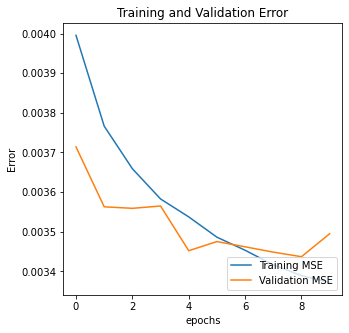

In [130]:
gray_ae = Autoencoder(latent_dim=64,input_dim=1,output_dim=2, strides=3, kernel_size = 5)
# Define optimizer and the error function
gray_ae.compile(optimizer='adam', loss=losses.MeanSquaredError(), metrics = "MeanSquaredError")
gray_history = gray_ae.fit(gray_train, chrom_train,
                epochs=10,
                shuffle=True,
                validation_data=(gray_val, chrom_val))

mse = gray_history.history['mean_squared_error']
val_mse = gray_history.history['val_mean_squared_error']

plot_training_curves(mse, val_mse)

188/188 [==============================] - 2s 11ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Test Error : [0.003995354752987623, 0.0037664934061467648, 0.003659080248326063, 0.0035828768741339445, 0.003537605283781886, 0.0034864728804677725, 0.003453495679423213, 0.003416703548282385, 0.0033896812237799168, 0.0033723204396665096]
RGB convertion


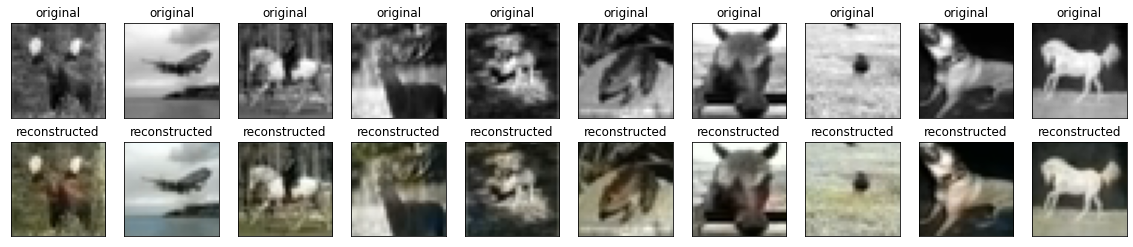

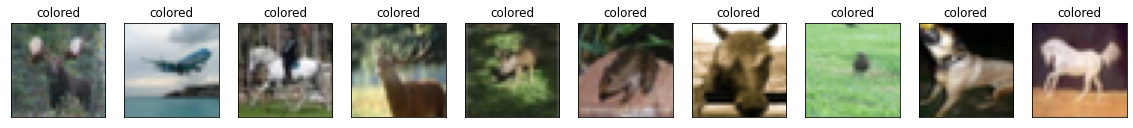

In [131]:
metrics = gray_ae.evaluate(gray_test,chrom_test)
mae = metrics[1]
print('Test Error :', mse)

plot_test(gray_ae,gray_test,gray = True,x_color = x_test)

In [134]:
class Autoencoder(Model):
    
  def __init__(self, latent_dim = 16, input_dim = 3, output_dim = 3, strides = 1, kernel_size = 3):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim   

    self.encoder = tf.keras.Sequential([
      layers.Conv2D(16, kernel_size=kernel_size, strides=1, padding='same', activation='relu', input_shape=(32,32,input_dim)),
    #   layers.AveragePooling2D(pool_size=(2, 2), padding='same'),
      layers.Conv2D(24, kernel_size=kernel_size, strides=strides, padding='same', activation='relu'),
    #   layers.AveragePooling2D(pool_size=(2, 2), padding='same'),
      layers.Conv2D(latent_dim, kernel_size=kernel_size, strides=strides, padding='same', activation='relu')
      # layers.Flatten(),
      # layers.Dense(latent_dim, activation='relu'),
    ])

    self.decoder = tf.keras.Sequential([
      layers.UpSampling2D(size=(strides-1,strides-1)),
      layers.Conv2D(24, kernel_size=kernel_size, strides=1, padding='same', activation='relu'),
      layers.UpSampling2D(size=(strides+1, strides+1)),
      layers.Conv2D(16, kernel_size=kernel_size, strides=1, padding='same', activation='relu'),
      layers.Dense(output_dim, activation='sigmoid')
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded


Epoch 1/10
1500/1500 [==============================] - 160s 106ms/step - loss: 0.0039 - mean_squared_error: 0.0039 - val_loss: 0.0037 - val_mean_squared_error: 0.0037
Epoch 2/10
1500/1500 [==============================] - 165s 110ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - val_loss: 0.0036 - val_mean_squared_error: 0.0036
Epoch 3/10
1500/1500 [==============================] - 155s 104ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - val_loss: 0.0035 - val_mean_squared_error: 0.0035
Epoch 4/10
1500/1500 [==============================] - 153s 102ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - val_loss: 0.0035 - val_mean_squared_error: 0.0035
Epoch 5/10
1500/1500 [==============================] - 151s 101ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - val_loss: 0.0034 - val_mean_squared_error: 0.0034
Epoch 6/10
1500/1500 [==============================] - 155s 103ms/step - loss: 0.0034 - mean_squared_error: 0.0034 - val_loss: 0.0035 - val_mean_squared_error:

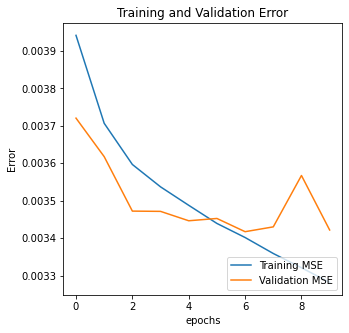

In [135]:
gray_ae = Autoencoder(latent_dim=64,input_dim=1,output_dim=2, strides=3, kernel_size = 5)
# Define optimizer and the error function
gray_ae.compile(optimizer='adam', loss=losses.MeanSquaredError(), metrics = "MeanSquaredError")
gray_history = gray_ae.fit(gray_train, chrom_train,
                epochs=10,
                shuffle=True,
                validation_data=(gray_val, chrom_val))

mse = gray_history.history['mean_squared_error']
val_mse = gray_history.history['val_mean_squared_error']

plot_training_curves(mse, val_mse)

In [1]:
metrics = gray_ae.evaluate(gray_test,chrom_test)
mae = metrics[1]
print('Test Error :', mse)

plot_test(gray_ae,gray_test,gray = True,x_color = x_test)

NameError: name 'gray_ae' is not defined

## Adding Data Augmentation

In [13]:
class Autoencoder(Model):
    
  def __init__(self, latent_dim = 16, input_dim = 3, output_dim = 3, strides = 1, kernel_size = 3):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim   

    self.encoder = tf.keras.Sequential([
      layers.experimental.preprocessing.RandomFlip('horizontal'),
      layers.experimental.preprocessing.RandomRotation(0.2),
      layers.Conv2D(16, kernel_size=kernel_size, strides=1, padding='same', activation='relu', input_shape=(32,32,input_dim)),
    #   layers.AveragePooling2D(pool_size=(2, 2), padding='same'),
      layers.Conv2D(24, kernel_size=kernel_size, strides=strides, padding='same', activation='relu'),
    #   layers.AveragePooling2D(pool_size=(2, 2), padding='same'),
      layers.Conv2D(latent_dim, kernel_size=kernel_size, strides=strides, padding='same', activation='relu')
      # layers.Flatten(),
      # layers.Dense(latent_dim, activation='relu'),
    ])

    self.decoder = tf.keras.Sequential([
      layers.UpSampling2D(size=(strides-1,strides-1)),
      layers.Conv2D(24, kernel_size=kernel_size, strides=1, padding='same', activation='relu'),
      layers.UpSampling2D(size=(strides+1, strides+1)),
      layers.Conv2D(16, kernel_size=kernel_size, strides=1, padding='same', activation='relu'),
      layers.Dense(output_dim, activation='sigmoid')
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded


Epoch 1/10
1500/1500 [==============================] - 169s 111ms/step - loss: 0.0041 - mean_squared_error: 0.0041 - val_loss: 0.0038 - val_mean_squared_error: 0.0038
Epoch 2/10
1500/1500 [==============================] - 162s 108ms/step - loss: 0.0039 - mean_squared_error: 0.0039 - val_loss: 0.0037 - val_mean_squared_error: 0.0037
Epoch 3/10
1500/1500 [==============================] - 163s 109ms/step - loss: 0.0038 - mean_squared_error: 0.0038 - val_loss: 0.0037 - val_mean_squared_error: 0.0037
Epoch 4/10
1500/1500 [==============================] - 169s 113ms/step - loss: 0.0038 - mean_squared_error: 0.0038 - val_loss: 0.0036 - val_mean_squared_error: 0.0036
Epoch 5/10
1500/1500 [==============================] - 166s 111ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - val_loss: 0.0037 - val_mean_squared_error: 0.0037
Epoch 6/10
1500/1500 [==============================] - 165s 110ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - val_loss: 0.0036 - val_mean_squared_error:

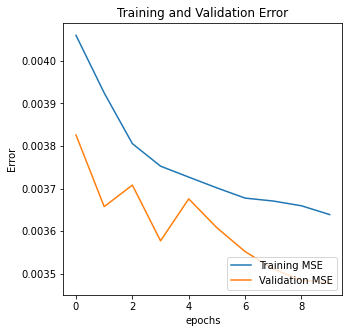

In [14]:
gray_ae = Autoencoder(latent_dim=64,input_dim=1,output_dim=2, strides=3, kernel_size = 5)
# Define optimizer and the error function
gray_ae.compile(optimizer='adam', loss=losses.MeanSquaredError(), metrics = "MeanSquaredError")
gray_history = gray_ae.fit(gray_train, chrom_train,
                epochs=10,
                shuffle=True,
                validation_data=(gray_val, chrom_val))

mse = gray_history.history['mean_squared_error']
val_mse = gray_history.history['val_mean_squared_error']

plot_training_curves(mse, val_mse)

In [15]:
metrics = gray_ae.evaluate(gray_test,chrom_test)
mae = metrics[1]
print('Test Error :', mse)

plot_test(gray_ae,gray_test,gray = True,x_color = x_test)

188/188 [==============================] - 3s 17ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Test Error : [0.004059892147779465, 0.003924726042896509, 0.00380563922226429, 0.003752723103389144, 0.003727092407643795, 0.003701708512380719, 0.0036777721252292395, 0.0036708859261125326, 0.0036597095895558596, 0.003639096859842539]
